## Purpose
Tests during development of vvmtools, plottools, etc.

### Import

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
from datetime import *
import glob
import logging

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn.colors.xkcd_rgb as c
import cmaps
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [2]:
import vvmtools as vvmtools_aaron

## VVMtools (data-related)

### Plan

- [X] func: convert_to_agird()
- [X] func: cal_tke(convert_to_agrid:bool)
- [X] func: cal_enstrophy(convert_to_agrid:bool)
- [X] func: cal_turb_flux(convert_to_agrid:bool)
- [ ] func: get_pbl_height(method:str)
    - [ ] func: _pbl_height_wth
    - [ ] func: _pbl_height_th05k
    - [ ] func: _pbl_height_dthdz

### Development

In [4]:
testcase = '/data/mlcloud/ch995334/VVM/DATA/pbl_mod_wfire_coastal_s1/'

In [39]:
class VVMtools(vvmtools_aaron.VVMTools):
    def __init__(self, casepath):
        super().__init__(casepath)
        
        self.TIMESTEPS = len(glob.glob(f"{casepath}/archive/*Dynamic*.nc"))

    def _Range_check_agrid(self, domain_range, conv_agrid:bool=False):
        """
        Default: conv_agrid set to FALSE because this function should be activated only when the conversion to a-grid is performed.
        """
        k1, k2, j1, j2, i1, i2 = domain_range
        # Check domain_range on the x-direction
        if i2 is not None and (i2 > 63):
            logging.warning(f"Grid {i2} on the x-axis is on/over the borderline "+ 
                            f"between two landtypes after interpolation (a-grid), "+ 
                            f"automatically set to 63.")
            i2           = 63
            domain_range = (k1, k2, j1, j2, i1, i2)
        if i1 is not None and (i1 < 64):
            logging.warning(f"Grid {i1} on the x-axis is on/over the borderline "+ 
                            f"between two landtypes after interpolation (a-grid), "+ 
                            f"automatically set to 64.")
            i1           = 64
            domain_range = (k1, k2, j1, j2, i1, i2)
        return domain_range
    
    
    def convert_to_agrid(self, var, time):
        """
        Default: Interpolate the entire domain on the designated time step.
        """
        # Wind field (u, v, w)
        if var == 'u':
            u_org   = self.get_var('u', time, numpy=True)
            u_agrid = (u_org[..., 1:]+u_org[..., :-1])/2   # itp_dim: (z, y, x) -> (x)
            return u_agrid[1:, :-1, :]                     # discard the last y and first z
        elif var == 'v':
            v_org   = self.get_var('v', time, numpy=True)
            v_agrid = (v_org[:, 1:, :]+v_org[:, :-1, :])/2 # itp_dim: (z, y, x) -> (y)
            return v_agrid[1:, :, :-1]                     # discard the last x and first z
        elif var == 'w':
            w_org   = self.get_var('w', time, numpy=True)
            w_agrid = (w_org[1:, ...]+w_org[:-1, ...])/2   # itp_dim: (z, y, x) -> (x)
            return w_agrid[:, :-1, :-1]                    # discard the last x and y
        
        # Vorticity field(eta, xi, zeta)
        elif var == 'eta':
            # Check dimension for the dynamic eta
            eta_temp = self.get_var('eta', 0, (1, 1, 1, 1, 1, 1), numpy=True)
            if len(eta_temp.shape) < 3:
                eta_org = self.get_var('eta_2', time, numpy=True)
            else:
                eta_org = self.get_var('eta', time, numpy=True)
            eta_agrid   = (eta_org[1:, :, 1:] +eta_org[1:, :, :-1]+      # itp_dim: (z, y, x)
                           eta_org[:-1, :, 1:]+eta_org[:-1, :, :-1])/4.  # -> (z, x)
            return eta_agrid[:, :-1, :]                                  # discard the last y
        elif var == 'xi':
            xi_org      = self.get_var('xi', time, numpy=True)  
            xi_agrid    = (xi_org[1:, 1:, :] +xi_org[1:, :-1, :]+        # itp_dim: (z, y, x)
                           xi_org[:-1, 1:, :]+xi_org[:-1, :-1, :])/4.    # -> (z, y)
            return xi_agrid[:, :, :-1]                                   # discard the last x
        elif var == 'zeta':
            zeta_org    = self.get_var('zeta', time, numpy=True)
            zeta_agrid  = (zeta_org[:, 1:, 1:] +zeta_org[:, 1:, :-1]+    # itp_dim: (z, y, x)
                           zeta_org[:, :-1, 1:]+zeta_org[:, :-1, :-1])/4.# -> (y, x)
            return zeta_agrid[1:, :, :]                                  # discard the first z
        
        # Theta (standard)
        elif var == 'th':
            th_org      = self.get_var('th', time, numpy=True)
            return th_org[1:, :-1, :-1]       # discard the first z, last y, last x
        
    def cal_TKE(self, time, domain_range, 
                conv_agrid:bool=True, 
                print_shape:bool=False):
        """
        Calculate TKE over the designated domain range and on the specified time step.
        Default:  u, v, w will be converted to a-grid before calculation.
        Default:  Calculate domain-average. TKE is only representative of turbulent motions when considering an area.
        Optional: Set print_shape=True to get the shape info of the retrieved u, v, w.
        """
        if conv_agrid:
            # Check domain_range on the x-direction
            domain_range           = self._Range_check_agrid(domain_range, conv_agrid)
            k1, k2, j1, j2, i1, i2 = domain_range
            # Get converted u, v, w
            u = self.convert_to_agrid('u', time)[k1:k2, j1:j2, i1:i2].copy()
            v = self.convert_to_agrid('v', time)[k1:k2, j1:j2, i1:i2].copy()
            w = self.convert_to_agrid('w', time)[k1:k2, j1:j2, i1:i2].copy()
        else:      
            u = np.squeeze(self.get_var("u", time, domain_range, numpy=True))
            v = np.squeeze(self.get_var("v", time, domain_range, numpy=True))
            w = np.squeeze(self.get_var("w", time, domain_range, numpy=True))
        # Provide shape info
        if print_shape: print("Shape of u, v, w:", u.shape, v.shape, w.shape)

        # POSSIBLE TODO: argument xarray:bool 
        # -> might be more convenient to entail variable info
        
        return np.nanmean((u**2+v**2+w**2)/2, axis=(1, 2))
    
    def cal_enstrophy(self, time, domain_range, 
                      conv_agrid:bool=True, 
                      print_shape:bool=False):
        """
        Calculate enstrophy over the designated domain range and on the specified time step.
        Default:  eta, xi, zeta will be converted to a-grid before calculation.
        Default:  Calculate domain-average. Enstrophy is only representative of turbulent motions when considering an area.
        Optional: Set print_shape=True to get the shape info of the retrieved eta, xi, zeta.
        """
        if conv_agrid:
            # Check domain_range on the x-direction
            domain_range           = self._Range_check_agrid(domain_range, conv_agrid)
            k1, k2, j1, j2, i1, i2 = domain_range
            # Get converted eta, xi, zeta
            eta  = self.convert_to_agrid('eta', time)[k1:k2, j1:j2, i1:i2].copy()
            xi   = self.convert_to_agrid('xi', time)[k1:k2, j1:j2, i1:i2].copy()
            zeta = self.convert_to_agrid('zeta', time)[k1:k2, j1:j2, i1:i2].copy()
        else: 
            ## Check dimension for the dynamic eta
            eta_temp = self.get_var('eta', 0, (1, 1, 1, 1, 1, 1), numpy=True)
            if len(eta_temp.shape) < 3:
                eta = np.squeeze(self.get_var("eta_2", time, domain_range, numpy=True))
            else:
                eta = np.squeeze(self.get_var("eta", time, domain_range, numpy=True))
            ## Other components of vorticity
            xi   = np.squeeze(self.get_var("xi", time, domain_range, numpy=True))
            zeta = np.squeeze(self.get_var("zeta", time, domain_range, numpy=True))
        # Provide shape info
        if print_shape: print("Shape of eta, xi, zeta:", eta.shape, xi.shape, zeta.shape)

        # POSSIBLE TODO: argument xarray:bool 
        # -> might be more convenient to entail variable info
        
        return np.nanmean((eta**2+xi**2+zeta**2), axis=(1, 2))
    
    def cal_turb_flux(self, time, domain_range, 
                      wind_var, prop_var,
                      conv_agrid:bool=True):
        """
        Params:
        wind_var is the medium [u/v/w].
        prop_var is the property transported by the medium.
        """
        if conv_agrid:
            # Check domain_range on the x-direction
            domain_range           = self._Range_check_agrid(domain_range, conv_agrid)
            k1, k2, j1, j2, i1, i2 = domain_range
            # Get converted variables
            windvar  = self.convert_to_agrid(wind_var, time)[k1:k2, j1:j2, i1:i2].copy()
            propvar  = self.convert_to_agrid(prop_var, time)[k1:k2, j1:j2, i1:i2].copy()
        else:
            windvar  = np.squeeze(self.get_var(wind_var, time, domain_range, numpy=True))
            propvar  = np.squeeze(self.get_var(prop_var, time, domain_range, numpy=True))
        # Calculate flux
        product_bar  = np.nanmean(windvar*propvar, axis=(-2, -1))
        wind_bar     = np.nanmean(windvar, axis=(-2, -1))
        prop_bar     = np.nanmean(propvar, axis=(-2, -1))
        return product_bar-(wind_bar*prop_bar)
    
    def get_pbl_height(self, time, domain_range, 
                       method:str, compute_mean_axis=None, 
                       conv_agrid:bool=True):
        """
        Available method now includes: 'wth', 'th05k', 'dthdz'
        """
        if method == 'wth':
            heights = self._pbl_height_wth(time, domain_range, conv_agrid)
        return heights
        
    def _pbl_height_wth(self, time, domain_range, 
                        conv_agrid:bool=True):
        """
        Default: domain-average (from the calculation of flux)
        """
        # Check domain_range on the x-direction
        if conv_agrid:
            domain_range = self._Range_check_agrid(domain_range, conv_agrid)
            z            = self.DIM['zc'][1:]
        else:
            z            = self.DIM['zc']
        # Method: wth
        wth_flux            = self.cal_turb_flux(time, domain_range, 'w', 'th', conv_agrid)
        sign_change_indices = (np.arange(z.shape[0]-1))[(wth_flux[:-1]*wth_flux[1:])<=0]    # apply to z
        if np.nanmax(wth_flux) < 0.005:
            sign_change_heights = np.array([0])
            neg_height_in_h1h2  = np.array([0])
        else:
            if sign_change_indices.shape[0]<1:           # no sign-change
                sign_change_heights = np.array([np.nan])
                neg_height_in_h1h2  = np.nan
            elif (sign_change_indices.shape[0]>0)&(sign_change_indices.shape[0]<2):  # only 1 sign-change
                sign_change_heights = (z[sign_change_indices]+z[sign_change_indices+1])/2
                neg_height_in_h1h2  = np.nan
            else:                    
                sign_change_heights= (z[sign_change_indices]+z[sign_change_indices+1])/2
                neg_idx_in_h1h2    = np.argmin(wth_flux[sign_change_indices[0]:sign_change_indices[1]+1])
                neg_height_in_h1h2 = (z[sign_change_indices[0]+neg_idx_in_h1h2]+z[sign_change_indices[0]+neg_idx_in_h1h2+1])/2
        
        result = {'sign_change_indices':sign_change_indices, 
                  'sign_change_mean_H':sign_change_heights, 
                  'neg_H_in_h1h2': neg_height_in_h1h2}
        return result

    
    def _pbl_height_th05k(self, time, domain_range,
                          compute_mean_axis=None,
                          conv_agrid:bool=True):
        """
        Default: No average. If compute_mean_axis is activated, 
        """
        
# Build test instance
test_vvmtools = VVMtools(testcase)

### Testing

In [48]:
print(test_vvmtools.get_pbl_height(350, (None, None, None, None, None, 64), 
                                  method='wth'))

{'sign_change_indices': array([21, 27, 37, 46]), 'sign_change_mean_H': array([0]), 'neg_H_in_h1h2': array([0])}


Text(0.5, 1.0, 'x=[0, 64)')

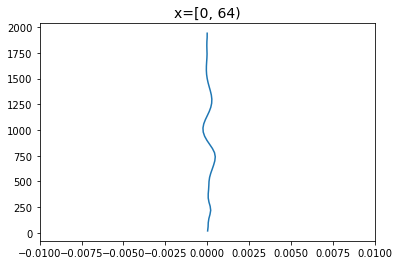

In [47]:
testprof = test_vvmtools.cal_turb_flux(350, (None, None, None, None, None, 64), 
                                       'w', 'th')
plt.plot(testprof, test_vvmtools.DIM['zc'][1:])
plt.xlim(-0.01, 0.01)
plt.title('x=[0, 64)', fontsize=14)

In [32]:
test_vvmtools.DIM

{'xc': array([  100.,   300.,   500.,   700.,   900.,  1100.,  1300.,  1500.,
         1700.,  1900.,  2100.,  2300.,  2500.,  2700.,  2900.,  3100.,
         3300.,  3500.,  3700.,  3900.,  4100.,  4300.,  4500.,  4700.,
         4900.,  5100.,  5300.,  5500.,  5700.,  5900.,  6100.,  6300.,
         6500.,  6700.,  6900.,  7100.,  7300.,  7500.,  7700.,  7900.,
         8100.,  8300.,  8500.,  8700.,  8900.,  9100.,  9300.,  9500.,
         9700.,  9900., 10100., 10300., 10500., 10700., 10900., 11100.,
        11300., 11500., 11700., 11900., 12100., 12300., 12500., 12700.,
        12900., 13100., 13300., 13500., 13700., 13900., 14100., 14300.,
        14500., 14700., 14900., 15100., 15300., 15500., 15700., 15900.,
        16100., 16300., 16500., 16700., 16900., 17100., 17300., 17500.,
        17700., 17900., 18100., 18300., 18500., 18700., 18900., 19100.,
        19300., 19500., 19700., 19900., 20100., 20300., 20500., 20700.,
        20900., 21100., 21300., 21500., 21700., 21900., 22

In [63]:
ds_test = xr.open_dataset(f"{testcase}/archive/pbl_mod_wfire_coastal_s1.L.Thermodynamic-000000.nc")

In [64]:
ds_test.th

<xarray.DataArray 'th' (time: 1, lev: 50, lat: 128, lon: 128)>
[819200 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 1900-01-01
  * lev      (lev) float64 0.0 0.02 0.06 0.1 0.14 ... 1.78 1.82 1.86 1.9 1.94
  * lat      (lat) float64 -0.1142 -0.1124 -0.1106 ... 0.1106 0.1124 0.1142
  * lon      (lon) float64 -0.1142 -0.1124 -0.1106 ... 0.1106 0.1124 0.1142
Attributes:
    standard_name:  potential_temperature
    long_name:      potential temperature
    units:          K

In [65]:
ds_test

<xarray.Dataset>
Dimensions:  (time: 1, lev: 50, lat: 128, lon: 128)
Coordinates:
  * time     (time) datetime64[ns] 1900-01-01
  * lev      (lev) float64 0.0 0.02 0.06 0.1 0.14 ... 1.78 1.82 1.86 1.9 1.94
  * lat      (lat) float64 -0.1142 -0.1124 -0.1106 ... 0.1106 0.1124 0.1142
  * lon      (lon) float64 -0.1142 -0.1124 -0.1106 ... 0.1106 0.1124 0.1142
Data variables: (12/13)
    zc       (lev) float64 ...
    yc       (lat) float64 ...
    xc       (lon) float64 ...
    th       (time, lev, lat, lon) float32 ...
    qv       (time, lev, lat, lon) float32 ...
    qc       (time, lev, lat, lon) float32 ...
    ...       ...
    qi       (time, lev, lat, lon) float32 ...
    nc       (time, lev, lat, lon) float32 ...
    nr       (time, lev, lat, lon) float32 ...
    ni       (time, lev, lat, lon) float32 ...
    qrim     (time, lev, lat, lon) float32 ...
    brim     (time, lev, lat, lon) float32 ...
Attributes:
    model_tag:     CSU VVM
    references:    http://kiwi.atmos.colostate.edu/pubs/joon-hee-tech_report.pdf
    contact:       jung@atmos.colostate.edu
    institution:   Colorado State University
    VVM_casename:  vvm_exp                                                   ...

## Plottools